In [0]:
# ! ls raw_data/Background/*

In [8]:
# ! git clone https://github.com/mghmgh1281375/trigger-word.git
# ! cat trigger-word/TARCHUNKS* > raw_data.tar.xz
# ! tar -xf raw_data.tar.xz
# ! for file in $(ls raw_data/Background/*.m4a);do ffmpeg -i raw_data/$file $file.wav; done
import os
black_list=("65-002.wav", "65-004.wav", "65-007.wav",  "66-011.wav", "67-006.wav")
for file in black_list:
  os.remove(os.path.join('raw_data', 'Background', file))
# ! 
# ! for file in $black_list;do rm raw_data/$file;done

# ! pip install pydub
! ls raw_data

Background  Negative  Positive


In [0]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import sys, os, io
import numpy as np
from pydub import AudioSegment
import random
import glob
import IPython
import time
from tqdm import tqdm
%matplotlib inline

In [0]:
# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate = wav_file.frame_rate
    data = wav_file.get_array_of_samples()
    data = np.array(data) # [len(data)//2:]
#     print(rate, len(data))
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    del(data)
    del(freqs)
    del(bins)
    del(im)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def load_raw_audio():
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("raw_data/Positive"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav("raw_data/Positive/"+filename)
            activates.append(activate)
    for filename in os.listdir("raw_data/Background"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("raw_data/Background/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("raw_data/Negative"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("raw_data/Negative/"+filename)
            negatives.append(negative)
    return activates, negatives, backgrounds

In [0]:
# Convert m4a to ffmpeg IMPORTANT

In [0]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [0]:
Ty = 1375 # The number of time steps in the output of our model

In [11]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(activates[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(activates[1])))     # Different "activate" clips can have different lengths 

background len: 9984
activate[0] len: 862
activate[1] len: 1286


The function `get_random_time_segment(segment_ms)` returns a random time segment onto which we can insert an audio clip of duration `segment_ms`. Read through the code to make sure you understand what it is doing. 


In [0]:
def get_random_time_segment(segment_ms):
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [0]:
def is_overlapping(segment_time, previous_segments):
    
    segment_start, segment_end = segment_time
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            return True

    return False

In [0]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. 
    segment_time = get_random_time_segment(segment_ms)
    _try = 0
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. 
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)
        _try += 1
        if _try == 5:
            return None, None

    # Step 3: Add the new segment_time to the list of previous_segments 
    previous_segments.append(segment_time)
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

Finally, implement code to update the labels $y^{\langle t \rangle}$, assuming you just inserted an "activate." In the code below, `y` is a `(1,1375)` dimensional vector, since $T_y = 1375$. 

If the "activate" ended at time step $t$, then set $y^{\langle t+1 \rangle} = 1$ as well as for up to 49 additional consecutive values. However, make sure you don't run off the end of the array and try to update `y[0][1375]`, since the valid indices are `y[0][0]` through `y[0][1374]` because $T_y = 1375$. So if "activate" ends at step 1370, you would get only `y[0][1371] = y[0][1372] = y[0][1373] = y[0][1374] = 1`


```
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
```

In [0]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_end_y+1, segment_end_y+51):
        if i < Ty:
            y[0, i] = 1.0
    
    return y

Finally, you can use `insert_audio_clip` and `insert_ones` to create a new training example.

**Exercise**: Implement `create_training_example()`. You will need to carry out the following steps:

1. Initialize the label vector $y$ as a numpy array of zeros and shape $(1, T_y)$.
2. Initialize the set of existing segments to an empty list.
3. Randomly select 0 to 4 "activate" audio clips, and insert them onto the 10sec clip. Also insert labels at the correct position in the label vector $y$.
4. Randomly select 0 to 2 negative audio clips, and insert them into the 10sec clip. 


## 1.4 - Full training set

You've now implemented the code needed to generate a single training example. We used this process to generate a large training set. To save time, we've already generated a set of training examples. 

In [0]:
def create_training_examples(background, activates, negatives):
    
    # Make background quieter
#     background = background - 20

    # Step 1: Initialize y (label vector) of zeros 
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list 
    previous_segments = []
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        if background is None:
            return None, None
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
        if background is None:
            return None, None
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -2.0)

    # Export new training example 
#     file_handle = background.export("train{}.wav".format(idx), format="wav")
#     print("File (train{}.wav) was saved in your directory.".format(idx))
    
#     Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
#     print(background.frame_rate, len(background.get_array_of_samples()[len(background.get_array_of_samples())//2:]))
    x = graph_spectrogram(background)
    del(background)
    del(previous_segments)
    del(number_of_activates) 
    del(random_indices)
    del(random_activates)
    del(number_of_negatives)
    del(random_negatives)
    
    return x, y

In [0]:
import lmdb
from pickle import dumps
import gc
env = lmdb.open('dataset', map_size=4900000*1700) # almost 10GB~9800MB

  2%|▏         | 24/1500 [00:04<05:31,  4.45it/s]/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
100%|██████████| 1500/1500 [04:35<00:00,  5.50it/s]


0

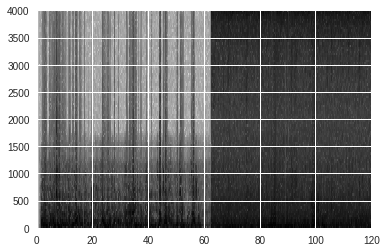

In [19]:
np.random.seed(18)

with env.begin(write=True, buffers=False) as txn:
    for i in tqdm(range(1500)):
        x, y = create_training_examples(backgrounds[i%len(backgrounds)], activates, negatives)
        if x is not None and x.shape[1] >= 5511:
            txn.put(str(i).encode(), dumps((np.swapaxes(x[:, :5511],0,1), y.reshape((1375, 1)))) )
        gc.collect()

del(activates)
del(negatives)
del(backgrounds)
gc.collect()

In [20]:
with env.begin() as txn:
    length = txn.stat()['entries']
    print(length)

803


In [0]:
# np.random.seed(18)
# import gc
# X, Y = [], []
# for i in tqdm(range(100)):
#     x, y = create_training_examples(backgrounds[i%len(backgrounds)], activates, negatives)
#     if x is not None:
#         X.append(np.swapaxes(x[:, :5511],0,1))
#         Y.append(y.reshape((1375, 1)))
#     gc.collect()
# print(len(X), len(Y))
# del(activates)
# del(negatives)
# del(backgrounds)
# gc.collect()

In [22]:
gc.collect()

46212

In [0]:
from pickle import loads
def gen():
  with env.begin() as txn:
    cursor = txn.cursor()
    for key, value in cursor:
      x, y = loads(value)
      yield np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)
# print(next(gen()))

# with env.begin(write=True, buffers=True) as txn:
#     for i in tqdm(range(500)):
#         x, y = create_training_examples(backgrounds[i%len(backgrounds)], activates, negatives, i)
#         if x is not None and x.shape[1] >= 5511:
#             txn.put(str(i).encode(), dumps((np.swapaxes(x[:, :5511],0,1), y.reshape((1375, 1)))) )


In [0]:

# import pickle
# pickle.dump(X, open('X.pickle', 'wb'))
# pickle.dump(Y, open('Y.pickle', 'wb'))

# ! ls -lh

# from google.colab import files
# files.download('X.pickle')
# files.download('Y.pickle')
# ! ls

## 1.5 - Development set

To test our model, we recorded a development set of 25 examples. While our training data is synthesized, we want to create a development set using the same distribution as the real inputs. Thus, we recorded 25 10-second audio clips of people saying "activate" and other random words, and labeled them by hand. We should create the dev set to be as similar as possible to the test set distribution; that's why our dev set uses real rather than synthesized audio. 


In [0]:
# Load preprocessed dev set examples
# X_dev = np.load("./XY_dev/X_dev.npy")
# Y_dev = np.load("./XY_dev/Y_dev.npy")

# 2 - Model

Now that you've built a dataset, lets write and train a trigger word detection model! 

The model will use 1-D convolutional layers, GRU layers, and dense layers. Let's load the packages that will allow you to use these layers in Keras. This might take a minute to load. 

In [23]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
      
    # Step 1: CONV layer
    X = Conv1D(196, 15, strides=4)(X_input)                    # CONV1D
    X = BatchNormalization()(X)                                # Batch normalization
    X = Activation('relu')(X)                                  # ReLu activation
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)

    # Step 2: First GRU Layer
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    # Step 3: Second GRU Layer
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [0]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375
model = model(input_shape = (Tx, n_freq))

Let's print the model summary to keep track of the shapes.

In [0]:
# model.summary()

The output of the network is of shape (None, 1375, 1) while the input is (None, 5511, 101). The Conv1D has reduced the number of steps from 5511 at spectrogram to 1375. 

## 2.2 - Fit the model

Trigger word detection takes a long time to train. To save time, we've already trained a model for about 3 hours on a GPU using the architecture you built above, and a large training set of about 4000 examples. Let's load the model. 

In [26]:
# model = load_model('./models/tr_model.h5')

/bin/bash: lspci: command not found


You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for one epoch and with a small training set of 26 examples. 

In [0]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [42]:
model.fit_generator(gen(), steps_per_epoch=800, epochs=300)

Epoch 1/300
800/800 [==============================] - 1120s 1s/step - loss: 1.1247 - acc: 0.5478
Epoch 2/300
  3/800 [..............................] - ETA: 18:22 - loss: 1.0658 - acc: 0.5629

StopIteration: ignored

In [0]:
# model.fit(X, Y, batch_size = 5, epochs=2)

## 2.3 - Test the model

Finally, let's see how your model performs on the dev set.

In [0]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

This looks pretty good! However, accuracy isn't a great metric for this task, since the labels are heavily skewed to 0's, so a neural network that just outputs 0's would get slightly over 90% accuracy. We could define more useful metrics such as F1 score or Precision/Recall. But let's not bother with that here, and instead just empirically see how the model does. 

# 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

<!--
can use your model to make predictions on new audio clips.

You will first need to compute the predictions for an input audio clip.

**Exercise**: Implement predict_activates(). You will need to do the following:

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. Use forward propagation on your model to compute the prediction at each output step
!-->

In [0]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

Once you've estimated the probability of having detected the word "activate" at each output step, you can trigger a "chiming" sound to play when the probability is above a certain threshold. Further, $y^{\langle t \rangle}$ might be near 1 for many values in a row after "activate" is said, yet we want to chime only once. So we will insert a chime sound at most once every 75 output steps. This will help prevent us from inserting two chimes for a single instance of "activate". (This plays a role similar to non-max suppression from computer vision.) 

<!-- 
**Exercise**: Implement chime_on_activate(). You will need to do the following:

1. Loop over the predicted probabilities at each output step
2. When the prediction is larger than the threshold and more than 75 consecutive time steps have passed, insert a "chime" sound onto the original audio clip

Use this code to convert from the 1,375 step discretization to the 10,000 step discretization and insert a "chime" using pydub:

` audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio.duration_seconds)*1000)
`
!--> 

In [0]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

## 3.3 - Test on dev examples

Let's explore how our model performs on two unseen audio clips from the development set. Lets first listen to the two dev set clips. 

In [0]:
IPython.display.Audio("./raw_data/dev/1.wav")

In [0]:
IPython.display.Audio("./raw_data/dev/2.wav")

Now lets run the model on these audio clips and see if it adds a chime after "activate"!

In [0]:
filename = "./raw_data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [0]:
filename  = "./raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

# 4 - Try your own example! (OPTIONAL/UNGRADED)

In this optional and ungraded portion of this notebook, you can try your model on your own audio clips! 

Record a 10 second audio clip of you saying the word "activate" and other random words, and upload it to the Coursera hub as `myaudio.wav`. Be sure to upload the audio as a wav file. If your audio is recorded in a different format (such as mp3) there is free software that you can find online for converting it to wav. If your audio recording is not 10 seconds, the code below will either trim or pad it as needed to make it 10 seconds. 


In [0]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

Once you've uploaded your audio file to Coursera, put the path to your file in the variable below.

In [0]:
your_filename = "audio_examples/my_audio.wav"

In [0]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded 

Finally, use the model to predict when you say activate in the 10 second audio clip, and trigger a chime. If beeps are not being added appropriately, try to adjust the chime_threshold.

In [0]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")